In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead")
    device = torch.device("cpu")

GPU is not available, using CPU instead


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('drive/My Drive/Konspektid Magister/Semester 2./Ärianalüütika/BDA Project/preprocessed_data_added.csv')
data.head()

,Text,Sentiment
0,still news roomhowever audio turn around grabb...,Neutral
1,saw fleetwood mac im insanely jealous dont eno...,Negative
2,theres one thing hate friends dats move skl fo...,Negative
3,think cheap sunglasses falling apart oh well,Negative
4,please read blog im best day,Negative


In [5]:
data['Sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [6]:
# Just in case, we shuffle the dataset
data.sample(frac=1, random_state=42).reset_index(drop=True)

,Text,Sentiment
0,dfizzy ever read uh got one question would eve...,Neutral
1,bother celebs eh cause almost like talking,Negative
2,piyaaa hi im hyper im bored im online im going...,Negative
3,best part notting hill daft prick haha love,Neutral
4,watching destrey videos,Neutral
...,...,...
23629,want garden sitting inside sunny sucks,Negative
23630,happy mothers day im spend day family,Positive
23631,moms season 3 weeds got burnt family friends m...,Negative
23632,wan na happy,Positive


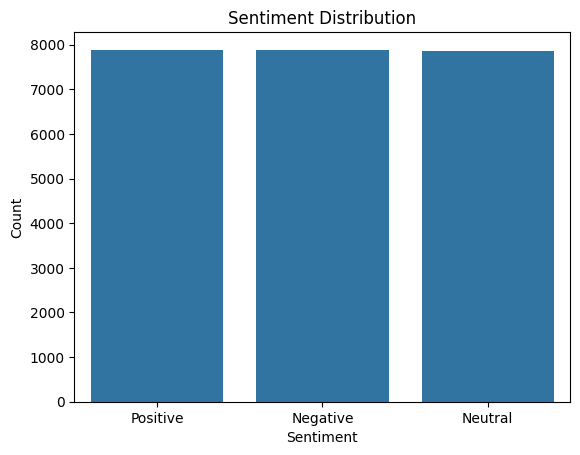

In [7]:
# Making sure that the dataset is balanced
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=data, x='Sentiment', order=data['Sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import product

# Splitting dataset into train, validation and test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(data['Text'], data['Sentiment'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Logistic Regression

In [9]:
def tune_logistic_regression(X_train, y_train, X_val, y_val, param_grid):

    best_model = None
    best_params = None
    best_score = 0

    param_combinations = product(*param_grid.values())

    for params in param_combinations:

        current_params = dict(zip(param_grid.keys(), params))
        print(current_params)
        model = LogisticRegression(**current_params)
        model.fit(X_train,y_train)
        val_predictions = model.predict(X_val)
        val_score = accuracy_score(y_val, val_predictions)
        print(f"Validation accuracy: {val_score:.4f}\n")

        if val_score > best_score:
          best_score = val_score
          best_model = model
          best_params = current_params

    print("Best Parameters:", best_params)
    print("Best Validation Accuracy:", best_score)

    return best_model, best_params, best_score

In [10]:
param_grid = {
    'C': [0.06, 0.1, 0.3, 0.6, 1, 3, 6, 7],
    'solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
    'max_iter': [1000]
}

best_model_lgr, best_params_lgr, best_score_lgr = tune_logistic_regression(X_train_vec, y_train, X_val_vec, y_val, param_grid)

{'C': 0.06, 'solver': 'lbfgs', 'max_iter': 1000}
Validation accuracy: 0.6454

{'C': 0.06, 'solver': 'sag', 'max_iter': 1000}
Validation accuracy: 0.6446

{'C': 0.06, 'solver': 'saga', 'max_iter': 1000}
Validation accuracy: 0.6444

{'C': 0.06, 'solver': 'newton-cg', 'max_iter': 1000}
Validation accuracy: 0.6446

{'C': 0.06, 'solver': 'liblinear', 'max_iter': 1000}
Validation accuracy: 0.6383

{'C': 0.1, 'solver': 'lbfgs', 'max_iter': 1000}
Validation accuracy: 0.6507

{'C': 0.1, 'solver': 'sag', 'max_iter': 1000}
Validation accuracy: 0.6502

{'C': 0.1, 'solver': 'saga', 'max_iter': 1000}
Validation accuracy: 0.6502

{'C': 0.1, 'solver': 'newton-cg', 'max_iter': 1000}
Validation accuracy: 0.6502

{'C': 0.1, 'solver': 'liblinear', 'max_iter': 1000}
Validation accuracy: 0.6473

{'C': 0.3, 'solver': 'lbfgs', 'max_iter': 1000}
Validation accuracy: 0.6740

{'C': 0.3, 'solver': 'sag', 'max_iter': 1000}
Validation accuracy: 0.6724

{'C': 0.3, 'solver': 'saga', 'max_iter': 1000}
Validation accur

In [11]:
from sklearn.metrics import classification_report

# Predicts and evaluates the best model on the test set
pred_lgr = best_model_lgr.predict(X_test_vec)
print(classification_report(y_test, pred_lgr))

              precision    recall  f1-score   support

    Negative       0.69      0.71      0.70      1561
     Neutral       0.58      0.59      0.59      1610
    Positive       0.74      0.72      0.73      1556

    accuracy                           0.67      4727
   macro avg       0.67      0.67      0.67      4727
weighted avg       0.67      0.67      0.67      4727



In [12]:
macro_f1_lgr = f1_score(y_test, pred_lgr, average='macro')
print(f"Logistic regression - macro F1 score: {macro_f1_lgr:.4f}")

Logistic regression - macro F1 score: 0.6729


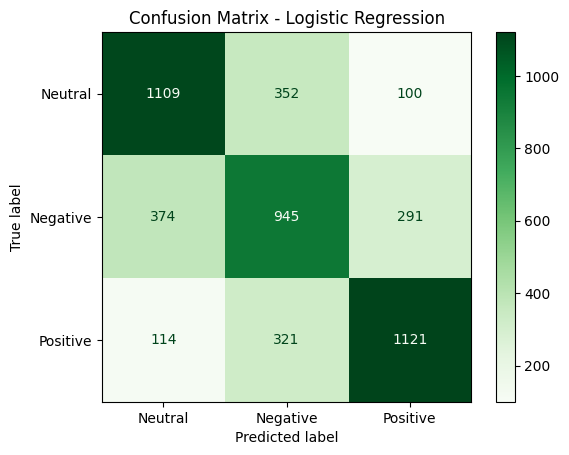

In [13]:
cm_lgr = confusion_matrix(y_test, pred_lgr)

labels = ['Neutral', 'Negative', 'Positive']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgr, display_labels=labels)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Random Forest classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

def tune_random_forest(X_train_vec, y_train, X_val_vec, y_val, param_grid):
    best_model = None
    best_params = None
    best_score = 0

    param_combinations = product(*param_grid.values())

    for params in param_combinations:
        current_params = dict(zip(param_grid.keys(), params))
        print(current_params)
        model = RandomForestClassifier(**current_params, random_state=42)
        model.fit(X_train_vec, y_train)
        val_predictions = model.predict(X_val_vec)
        val_score = accuracy_score(y_val, val_predictions)
        print(f"Validation accuracy: {val_score:.4f}\n")

        if val_score > best_score:
            best_score = val_score
            best_model = model
            best_params = current_params

    print("Best Parameters:", best_params)
    print("Best Validation Accuracy:", best_score)

    return best_model, best_params, best_score

In [15]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 3, 4, 5]
}

In [16]:
best_model_rf, best_param_rf, best_score_rf = tune_random_forest(X_train_vec, y_train, X_val_vec, y_val, param_grid)

{'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2}
Validation accuracy: 0.6719

{'n_estimators': 50, 'max_depth': None, 'min_samples_split': 3}
Validation accuracy: 0.6785

{'n_estimators': 50, 'max_depth': None, 'min_samples_split': 4}
Validation accuracy: 0.6745

{'n_estimators': 50, 'max_depth': None, 'min_samples_split': 5}
Validation accuracy: 0.6798

{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}
Validation accuracy: 0.6192

{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 3}
Validation accuracy: 0.6208

{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 4}
Validation accuracy: 0.6185

{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}
Validation accuracy: 0.6195

{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2}
Validation accuracy: 0.6423

{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 3}
Validation accuracy: 0.6404

{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 4}
Validation accuracy:

In [17]:
pred_rf = best_model_rf.predict(X_test_vec)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

    Negative       0.72      0.68      0.70      1561
     Neutral       0.60      0.64      0.62      1610
    Positive       0.76      0.75      0.75      1556

    accuracy                           0.69      4727
   macro avg       0.69      0.69      0.69      4727
weighted avg       0.69      0.69      0.69      4727



In [18]:
macro_f1_rf = f1_score(y_test, pred_rf, average='macro')
print(f"Random Forest - macro F1 score: {macro_f1_rf:.4f}")

Random Forest - macro F1 score: 0.6908


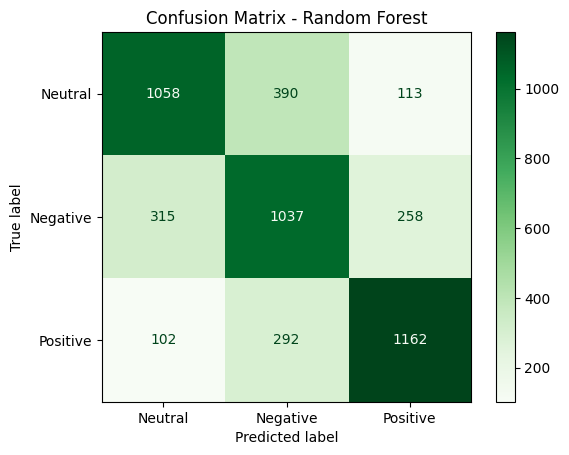

In [19]:
cm_rf = confusion_matrix(y_test, pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Fine-tuning pretrained ModernBERT model
Converting the dataset into the correct format.

In [ ]:
_ = !pip install -U datasets

In [ ]:
from transformers import AutoTokenizer

checkpoint = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from datasets import Dataset, DatasetDict

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df   = pd.DataFrame({'text': X_val, 'label': y_val})
test_df  = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)

train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 15125
})

In [ ]:
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
val_dataset   = val_dataset.remove_columns(["__index_level_0__"])
test_dataset  = test_dataset.remove_columns(["__index_level_0__"])

train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 15125
})

In [ ]:
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15125
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3782
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4727
    })
})

In [ ]:
id2label = {0: "Neutral", 1: "Negative", 2: "Positive"}
label2id = {"Neutral": 0, "Negative": 1, "Positive": 2}

In [ ]:
def encode_labels(example):
    example['label'] = label2id[example['label']]
    return example

dataset_dict = dataset_dict.map(encode_labels)

Map:   0%|          | 0/15125 [00:00<?, ? examples/s]

Map:   0%|          | 0/3782 [00:00<?, ? examples/s]

Map:   0%|          | 0/4727 [00:00<?, ? examples/s]

In [ ]:
def tokenize_function(text):
    return tokenizer(text["text"], truncation=True)

In [ ]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/15125 [00:00<?, ? examples/s]

Map:   0%|          | 0/3782 [00:00<?, ? examples/s]

Map:   0%|          | 0/4727 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 15125
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3782
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4727
    })
})

In [ ]:
# Transformer models like BERT require that all input texts in a batch have the same length but our tokenized texts have different length.
# Therefore we need DataCollatorWithPadding as it automatically pads inputs to the length of the longest text in the batch.
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Preprocessing tokenized dataset in a format required for the pretrained model
tokenized_datasets = tokenized_datasets.remove_columns('text')
tokenized_datasets = tokenized_datasets.rename_column('label','labels')
tokenized_datasets.set_format(type='torch')
print(tokenized_datasets['train'].column_names)

['labels', 'input_ids', 'attention_mask']


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=32, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=32, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=32, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([32]),
 'input_ids': torch.Size([32, 26]),
 'attention_mask': torch.Size([32, 26])}

In [ ]:
# It loads a pretrained transformer model like BERT, adds a classification head and configures everything for classifying input texts.
from transformers import AutoModelForSequenceClassification

model_bert = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_bert.to(device)

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

In [ ]:
from transformers import Trainer, TrainingArguments

def train_and_eval_model(model, hparams, checkpoint, tokenized_datasets):

    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=hparams['learning_rate'],
        per_device_train_batch_size=hparams['batch_size'],
        per_device_eval_batch_size=hparams['batch_size'],
        num_train_epochs=hparams['epochs'],
        weight_decay=hparams.get('weight_decay', 0.01),
        report_to="none",
        logging_dir=None,
        logging_steps=10
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results["eval_accuracy"], model, hparams

In [ ]:
param_grid = {
    "learning_rate": [2e-5, 3e-5, 5e-5],
    "batch_size": [8, 16],
    "epochs": [2, 3]
}

best_score = 0
best_model = None
best_params = None

for values in product(*param_grid.values()):
    hparams = dict(zip(param_grid.keys(), values))
    print(hparams)
    score, model, used_params = train_and_eval_model(model_bert ,hparams, checkpoint, tokenized_datasets)
    print(f"Validation Accuracy: {score:.4f}")

    if score > best_score:
        best_score = score
        best_model = model
        best_params = used_params

best_model.save_pretrained("best_model/")
tokenizer.save_pretrained("best_model/")

print("Best score:", best_score)
print("Best parameters:", best_params)

{'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 2}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
W0604 20:02:19.871000 245 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy
1,0.605600,0.581387,0.763882
2,0.294400,0.646102,0.764939


Validation Accuracy: 0.7649
{'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.481800,0.838873,0.747753
2,0.158100,1.438116,0.746959
3,0.004900,2.254251,0.745108


Validation Accuracy: 0.7451
{'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 2}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.052900,2.482021,0.742200
2,0.000400,2.624651,0.749075


Validation Accuracy: 0.7491
{'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.012600,2.606950,0.741671
2,0.000300,2.878307,0.744580
3,0.062600,2.924409,0.753041


Validation Accuracy: 0.7530
{'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 2}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.225600,3.027358,0.739291
2,0.120600,2.971681,0.747224


Validation Accuracy: 0.7472
{'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 3}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.322200,3.010278,0.728979
2,0.000700,2.672426,0.746166
3,0.000000,3.060601,0.748810


Validation Accuracy: 0.7488
{'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 2}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000300,2.836256,0.749603
2,0.000200,2.828772,0.751719


Validation Accuracy: 0.7517
{'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 3}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.025200,2.995363,0.747753
2,0.003400,2.991602,0.745373
3,0.021600,3.108262,0.744844


Validation Accuracy: 0.7448
{'learning_rate': 5e-05, 'batch_size': 8, 'epochs': 2}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.106400,2.462060,0.727922
2,0.000100,2.758303,0.740878


Validation Accuracy: 0.7409
{'learning_rate': 5e-05, 'batch_size': 8, 'epochs': 3}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.069400,1.771805,0.734532
2,0.020200,2.029357,0.735854
3,0.000000,2.376944,0.744051


Validation Accuracy: 0.7441
{'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 2}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.022600,1.994737,0.742464
2,0.002000,2.227563,0.741142


Validation Accuracy: 0.7411
{'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 3}


<ipython-input-34-2481ff29e19c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.099000,1.928929,0.739027
2,0.000600,2.029079,0.736647
3,0.042400,2.228235,0.741142


Validation Accuracy: 0.7411
Best score: 0.7649391856160761
Best parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 2}


In [ ]:
!zip -r best_model.zip best_model/

  adding: best_model/ (stored 0%)
  adding: best_model/config.json (deflated 58%)
  adding: best_model/special_tokens_map.json (deflated 79%)
  adding: best_model/tokenizer.json (deflated 82%)
  adding: best_model/tokenizer_config.json (deflated 95%)
  adding: best_model/model.safetensors (deflated 7%)


In [ ]:
from google.colab import files
files.download("best_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
_ = !unzip best_model.zip

In [ ]:
# Loading the pretrained models
model_bert = AutoModelForSequenceClassification.from_pretrained("best_model/")
tokenizer = AutoTokenizer.from_pretrained("best_model/")

In [ ]:
model_bert.eval()
pred_bert = []
labels_bert = []

for batch in test_dataloader:
    batch = {k: v.to(model_bert.device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model_bert(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    pred_bert.extend(predictions.cpu().tolist())
    labels_bert.extend(batch["labels"].cpu().tolist())

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels_bert, pred_bert, target_names=model_bert.config.id2label.values()))

              precision    recall  f1-score   support

     Neutral       0.67      0.68      0.68      1610
    Negative       0.77      0.74      0.76      1561
    Positive       0.78      0.79      0.78      1556

    accuracy                           0.74      4727
   macro avg       0.74      0.74      0.74      4727
weighted avg       0.74      0.74      0.74      4727



In [ ]:
macro_f1_bert = f1_score(labels_bert, pred_bert, average='macro')
print(f"ModernBERT - macro F1 score: {macro_f1_bert:.4f}")

ModernBERT - macro F1 score: 0.7380


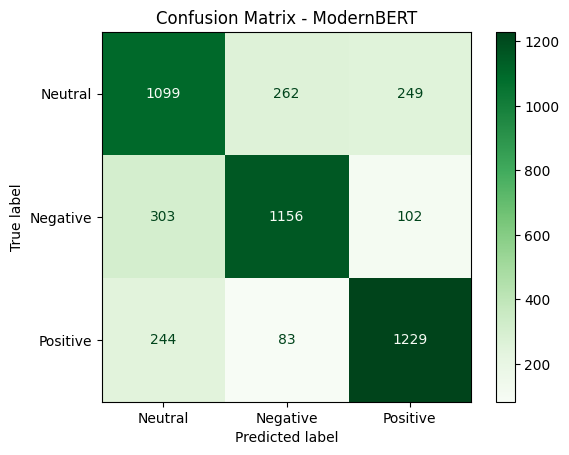

In [ ]:
cm_bert = confusion_matrix(labels_bert, pred_bert)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=label2id)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - ModernBERT")
plt.show()